# <font color= orange>**Agent Loop and Runner**</font>

# <font color=orange> **Runner Methods** <font/>

### **Runner.run()**
This is an asynchronous method, for non blocking execution.
* Runs in async mode (you need await)
* Good for apps that already run in async environments
* Handles agent looping until done
* Can return any type of final output the agent is designed for

```
result = await Runner.run(
    starting_agent=my_agent,
    input="Hello!",
    max_turns=5
)
```

### **Runner.run_sync()**
This is  synchronous method, it warps Runner.run() internally and provides a blocking interface.
```
result = Runner.run_sync(
    starting_agent=my_agent,
    input="Hello!"
)
```
* Synchronous (no await)
* Perfect for small scripts
* Literally just wraps around run() but  blocks until finished
* Will not work if you already have an async event loop (like in Jupyter)

### **Runner.run_streamed()**
This is an asynchronous method that provides streaming capabilities, allowing for real-time updates.
```
stream = Runner.run_streamed(
    starting_agent=my_agent,
    input="Hello!"
)
for event in stream.stream_events():
    print(event)
```
* Starts the agent in streaming mode
* Lets you see events as they happen
* Useful for real-time UI updates or progress indicators
* Returns a RunResultStreaming object

**How the Loop Works**
Here’s the brain flow inside the runner:

1. Send input to agent
2. If final answer found → stop & return it
3. If agent hands off → run new agent
4. If agent wants tools → run them & repeat
5. If turns > max_turns → throw MaxTurnsExceeded
6. If guardrail trips → throw GuardrailTripwireTriggered



# **What is the Agent Loop?**

The **agent loop** is the cycle an **AI agent** follows when reasoning and acting in the world.
Instead of just generating one reply, the LLM repeatedly:

1. **Receives Input** (user request + context)
2. **Thinks/Reasons** (decides what to do)
3. **Acts** (calls a tool, queries database, or generates a reply)
4. **Observes Result** (tool output, new data)
5. **Loops Back** → continues reasoning until goal is done

---

## **Why is it Needed?**

* A plain LLM just outputs text (one-shot).
* But **real-world tasks are multi-step** (e.g., “Plan me a 3-day Tokyo trip, book flights, and estimate costs”).
* The agent loop allows the LLM to:

  * Break down the task into steps
  * Call tools/APIs to gather fresh info
  * Refine its plan step by step
  * Stop once the task is complete

Without looping, the LLM would try to do everything in one giant answer (often inaccurate).

<br>

---

<br>

## **Agent Loop in Action (Example)**

### Task: “What’s the population of Paris squared?”

* **Step 1 (Reason):** LLM decides → “I don’t know population, need to use search tool.”
* **Step 2 (Act):** Calls `search_tool("population of Paris")`.
* **Step 3 (Observe):** Tool returns `2,161,000`.
* **Step 4 (Reason):** LLM decides → “Now I need a calculator.”
* **Step 5 (Act):** Calls `calculator(2161000 ** 2)`.
* **Step 6 (Observe):** Gets `4,668,721,000,000`.
* **Step 7 (Respond):** Returns final answer to user.

This back-and-forth continues until the goal is reached → that’s the **agent loop**.

<br>

---

<br>

## **How It Looks (Cycle Diagram)**

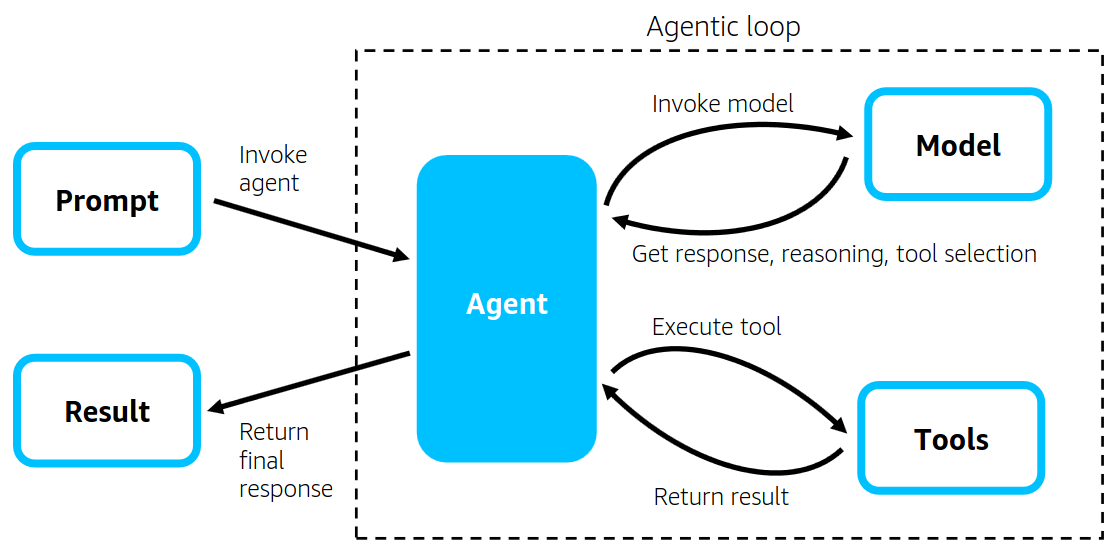

<br>

---

<br>

## **Where Does It Live?**

* In **OpenAI Agents SDK** → the loop is built-in:

  * LLM decides → calls tool → agent SDK handles the cycle.
* In **LangChain** → same idea with `ReAct` framework (Reason + Act).
* In **AutoGPT** (2023 hype) → agent loop ran until user stopped it.

<br>

---

<br>

### **Summary**

* **Agent loop** = think → act → observe → repeat.
* Allows LLMs to handle **multi-step reasoning and tool usage**.
* Without it, LLMs are just “smart parrots” → with it, they become **agents** that can solve real tasks.



## **What is a Triage Agent?**

A Triage Agent is a specialized coordinator agent whose only job is:

> Look at the user’s request and decide which agent (or workflow) should handle it.

It doesn’t solve the problem itself (like Researcher, Writer, Editor).
Instead, it acts like a dispatcher / router / receptionist.

## **How It Works in the Agent Loop**

1. User input comes into the system.

2. Instead of directly sending it to a domain agent (like Researcher or Writer), it first goes to the Triage Agent.

3. The Triage Agent looks at the input and decides:

   * Which agent should handle this?

   * Or should it split the task into multiple sub-requests?

4. It passes the query to the correct agent.

5. That agent then runs its own loop until completion.

6. The Runner manages the orchestration.

## **Putting it all together (code you can adapt)**

Below are two layers of loops:

* **Loop A:** the **triage agent** runs its own agent loop to pick a target.

* **Loop B:** the **chosen domain agent** runs its loop to solve the task.

In [ ]:
from agents import Agent, Runner, OpenAIChatCompletionsModel, AsyncOpenAI
from agents.run import RunConfig
import json

client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)
triage_model   = OpenAIChatCompletionsModel(model="gemini-2.5-flash", openai_client=client)
coder_model    = OpenAIChatCompletionsModel(model="gemini-2.5-flash", openai_client=client)
teacher_model  = OpenAIChatCompletionsModel(model="gemini-2.5-flash", openai_client=client)
support_model  = OpenAIChatCompletionsModel(model="gemini-2.5-flash", openai_client=client)

# -------- Domain agents (each has its own persona/tools/model) --------
coder = Agent(
    name="Coder",
    instructions="You write and explain code. Prefer Python. Provide runnable, minimal examples.",
    model=coder_model,
)

teacher = Agent(
    name="Teacher",
    instructions="You explain complex topics simply with examples and step-by-step scaffolding.",
    model=teacher_model,
)

support = Agent(
    name="Support",
    instructions="You answer product usage questions, give concise steps, and ask clarifying questions when needed.",
    model=support_model,
)

# -------- Triage agent (router) --------
triage = Agent(
    name="Triage",
    model=triage_model,
    instructions=(
        "You are a dispatcher. Read the user request and choose ONE target: "
        "Coder, Teacher, or Support. "
        "Return ONLY a compact JSON object with keys: target, reasoning. "
        "Example: {\"target\":\"Coder\",\"reasoning\":\"Wants Python code.\"}"
        "Do NOT solve the task."
    )
)


def route_and_solve(user_input: str) -> str:
    # ---- Loop A: run triage (its own agent loop) ----
    triage_result = Runner.run_sync(
        starting_agent=triage,
        input=user_input,
        run_config=triage_run
    )
    raw = triage_result.final_output

    # Be robust to non-perfect JSON
    target = "Support"
    try:
        data = json.loads(raw)
        target = data.get("target", "Support")
    except Exception:
        # fallback when model didn’t return JSON
        if "code" in raw.lower() or "python" in raw.lower():
            target = "Coder"
        elif "explain" in raw.lower() or "learn" in raw.lower():
            target = "Teacher"

    # ---- Choose the domain agent ----
    selected = {"Coder": coder, "Teacher": teacher, "Support": support}.get(target, support)

    # Optional: per-task overrides (RunConfig)
    domain_run = RunConfig(
        model=selected.model,           # could swap to a beefier model if needed
        model_provider=client,
        tracing_disabled=True
    )

    # ---- Loop B: run the chosen agent (its own agent loop) ----
    solved = Runner.run_sync(
        starting_agent=selected,
        input=user_input,
        run_config=domain_run
    )
    return solved.final_output

# Example:
print(route_and_solve("Write a Python function that reverses a string."))
print(route_and_solve("Explain Agentic AI like I’m 10."))
print(route_and_solve("How do I set RunConfig in the Agents SDK?"))


## **Agent Loop Recap**

An **agent loop** is the cycle of reasoning the SDK runs:

1. Agent receives **input** (user message or another agent’s handoff).
2. Agent thinks:

   * Should I answer directly?
   * Should I call a **tool**?
   * Should I **handoff** to another agent?
3. SDK executes the tool / handoff if needed.
4. The result goes back into the agent.
5. Repeat until **final\_output** is produced.

<br>

---

<br>

# **How Many Times Does the Loop Run?**

👉 **It depends on the agent’s reasoning.**

* If the agent **answers directly**, the loop runs **once**.
* If the agent needs to call a tool:

  * One loop to decide *“call tool X”*.
  * Another loop after the tool result is returned, to decide *“now I can answer”*.
  * So usually **2 loops**.
* If multiple tools are called in sequence, each call adds another loop.

<br>

---

<br>

# **Example Walkthrough**

### **Case 1 — Direct Answer**

```text
User: "Who is the President of the US?"
Agent: "The current president is Joe Biden."
```

* Loop runs **1 time**.
* No tool, no handoff, just reasoning → answer.

---<br>

---

<br>

### **Case 2 — One Tool Call**

```text
User: "What’s the weather in Karachi?"
Agent (loop 1): "I should call tool: get_weather(city='Karachi')."
Tool executes → "Sunny, 30°C."
Agent (loop 2): "The weather in Karachi is Sunny, 30°C."
```

* Loop runs **2 times**.
* 1st loop = decide to use tool.
* 2nd loop = consume tool output, finalize answer.

<br>

---

<br>

### **Case 3 — Multiple Tool Calls**

```text
User: "What’s the square root of today’s temperature in Karachi?"
Agent (loop 1): call `get_weather('Karachi')`  
Tool result: 30  
Agent (loop 2): call `math.sqrt(30)`  
Tool result: 5.477  
Agent (loop 3): "The square root of today’s temperature (30) is 5.477."
```

* Loop runs **3 times**.

<br>

---

<br>

### **Case 4 — Handoff**

```text
User: "Solve 23 * 47."
Triage Agent (loop 1): "This is math. Handoff to MathAgent."
MathAgent (loop 2): "23 * 47 = 1081."
```

* Each agent adds a loop.
* Total = **2 loops** here (triage + math).

<br>

---

<br>

# **Key Point**

The loop runs **as many times as needed** until:

* The agent produces a `final_output`, or
* A maximum loop limit is hit (SDK safety feature to prevent infinite loops).

In practice:

* **Simple Q\&A** → 1 loop
* **1 tool** → 2 loops
* **Multiple tools / handoffs** → 3+ loops

<br>

---

<br>

**In short:**
An agent loop is iterative.
Every tool call or handoff adds another loop.
It ends when the agent produces the final answer.
